# Bayesian Optimization on a 1-dim function

Let's apply our methods for Bayesian Optimization on a one-dimensional function to see how it performs.

This notebook is created with docker-stacks: https://github.com/jupyter/docker-stacks

In [1]:
%%init_spark
# Configure Spark to use a local master
launcher.master = "local"
launcher.jars = ["/home/jovyan/jars/assembly.jar"]

In [2]:
sc.version

Intitializing Scala interpreter ...

Spark Web UI available at http://4c454274fcb8:4040
SparkContext available as 'sc' (version = 3.0.1, master = local, app id = local-1609673719309)
SparkSession available as 'spark'


res0: String = 3.0.1


In [3]:
%%python
import matplotlib
matplotlib.use("agg")
from matplotlib import pyplot as plt
from IPython.display import Image
import tempfile
import numpy as np

## Objective Function

We will try to find the maximum of the following objective function for x-values between 0 and 1.

In [4]:
val square: Double => Double = x => x * x

val objective: Double => Double = xRaw => {
    val x = xRaw * 12 - 2
    val y = Math.exp(- square(x - 2)) + Math.exp( -(square(x - 6) / 10)) + 1 / (square(x) + 1)
    y / 6
}

square: Double => Double = $Lambda$1892/0x0000000840baa040@78f6c39b
objective: Double => Double = $Lambda$1893/0x0000000840bb8840@355867b4


Let's create some values in order to plot the objective.

In [5]:
val xRange = (0d to 1d by 0.01).toSeq
val yRange = xRange.map(objective)
val df = (xRange zip yRange).toDF("x", "y")

xRange: scala.collection.immutable.Seq[Double] = NumericRange 0.0 to 1.0 by 0.01
yRange: scala.collection.immutable.Seq[Double] = Vector(0.03361027830139144, 0.03709116617458117, 0.0410785694295823, 0.04565859170204616, 0.05093038168387631, 0.0570055697360936, 0.06400520751053461, 0.07205219282928273, 0.08125608736351526, 0.09168606519607686, 0.10332720503265837, 0.11601729573930653, 0.12936912824444274, 0.14270069574430344, 0.15502166232884074, 0.16514221904158985, 0.17194374547456118, 0.17475407606397145, 0.17365317098344255, 0.16952302610251566, 0.1638049969631072, 0.15811026479435666, 0.1538754220053404, 0.15216166068651885, 0.1535859719497652, 0.1583274066325569, 0.16616244862800353, 0.17651133835184663, 0.1884970139349332, 0.20102475806497713, 0.21288709701891576, 0.22289008618727...


In [6]:
df.createOrReplaceTempView("objective")

In [7]:
%%python
df = np.array(spark.sql("select x,y from objective").collect())
dfx = df[:,0]
dfy = df[:,1]

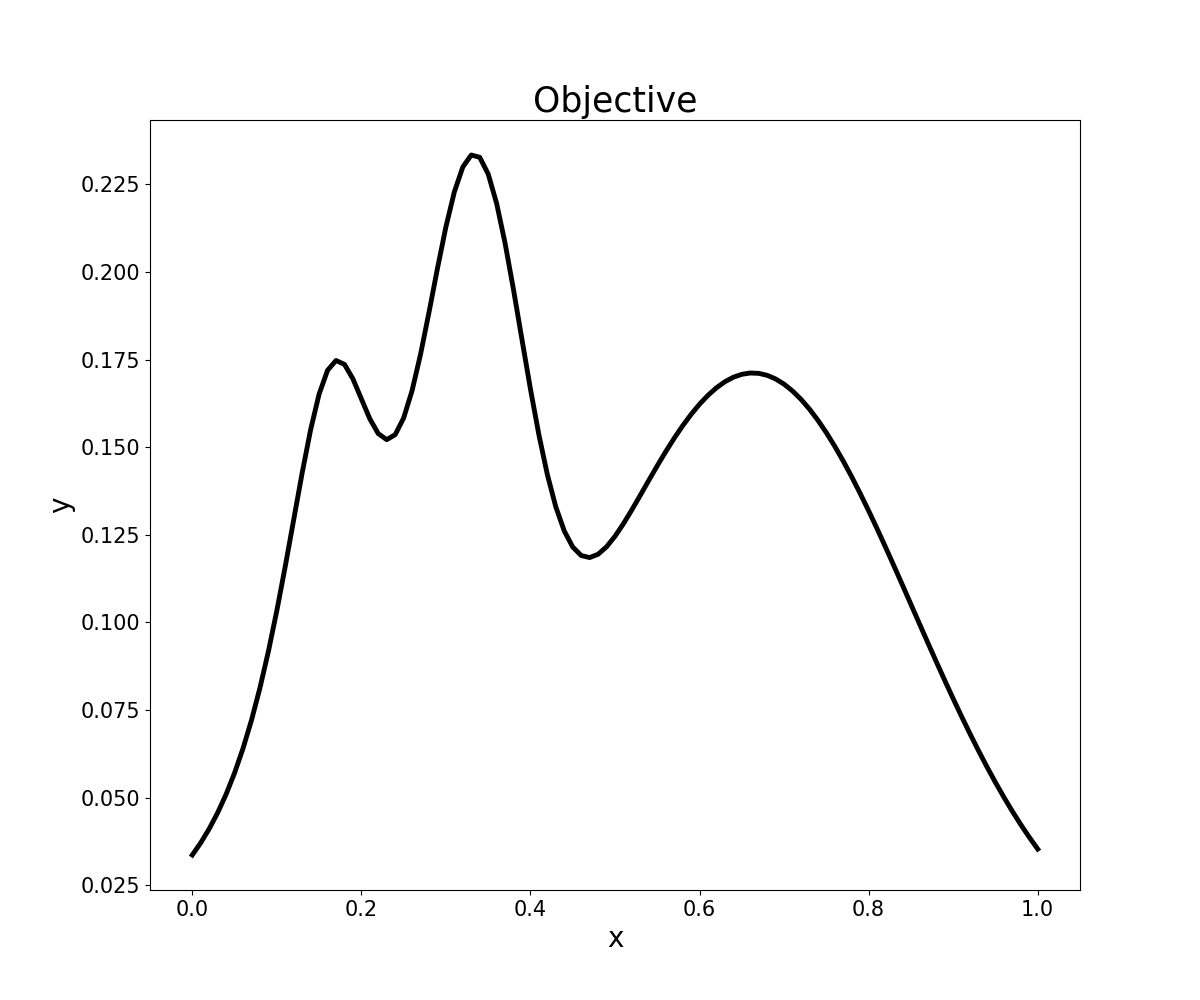

In [8]:
%%python
fig = plt.figure(figsize=[12,10])
ax = fig.add_subplot(1,1,1)
ax.plot(dfx,dfy,'k', linewidth=3.5)
ax.set_title("Objective", fontsize=25)
ax.set_xlabel("x", fontsize=20)
ax.set_ylabel("y", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    fig.savefig(fo.name)
    retval = Image(filename=fo.name)

We can see now, that our objective is a function with 3 local maximas, a good presetting to test our optimization algorithm.

## Setup Bayesian Optimization

In [9]:
import com.agoda.ml.spark.hpopt.BayesianHyperparameterOptimization
import com.agoda.ml.spark.hpopt.hyperparam.{DoubleHyperparameterType, HyperparameterEvalPoint, HyperparameterSpace, LinearScale}

import com.agoda.ml.spark.hpopt.BayesianHyperparameterOptimization
import com.agoda.ml.spark.hpopt.hyperparam.{DoubleHyperparameterType, HyperparameterEvalPoint, HyperparameterSpace, LinearScale}


We will treat our objective function like a machine learning problem. The input value x is a hyperparameter and the function value is the metric we try to maximize. Let's start by defining our hyperparameter space.

In [10]:
val hpSpace = HyperparameterSpace(Array(
    DoubleHyperparameterType("x", LinearScale(0, 1))
))

hpSpace: com.agoda.ml.spark.hpopt.hyperparam.HyperparameterSpace = HyperparameterSpace([Lcom.agoda.ml.spark.hpopt.hyperparam.HyperparameterType;@47a46d4e,None)


Now, we are ready to create an instance of BayesianHyperparameterOptimization, the main entry point to the algorithm. Here we can set all the options like the hyperparameter space, the Gaussian Process Kernel, the acquisition function, how many Monte Carlo steps we want to take to evaluate the acquisition function and if we want to maximize or minimize. We will go with the default options and only set our hyperparameter space and maximize to true.

In [11]:
val bho = new BayesianHyperparameterOptimization(
    hpSpace,
    maximize = true
)

bho: com.agoda.ml.spark.hpopt.BayesianHyperparameterOptimization = com.agoda.ml.spark.hpopt.BayesianHyperparameterOptimization@4fea0804


The framework gives us full control over each evaluation step. The BayesianHyperparameterOptimization instance only provides us with a recommendation of the next hyperparameter values to evaluate, the rest is up to the end user.

In [12]:
// We want to do 40 iterations in total and start with 5 random iterations before we use the Gaussian Process.
val randomIterations = 5
val iterations = 40

// Each step we have access to the previous hyperparameters and metric values
def iterationStep(
    step: Int,
    previousHP: Array[HyperparameterEvalPoint] = Array.empty[HyperparameterEvalPoint],
    previousMetrics: Array[Double] = Array.empty[Double]
): (Array[HyperparameterEvalPoint], Array[Double]) = {
    
    // Depending on the step count we determine the next hyperparameters to evaluate randomly or by Bayesian Optimization
    val nextHP = if (step < randomIterations) bho.getNextRandom else bho.getNext(previousHP, previousMetrics)
    // If we use sparks PipelineStage s, the framework provides us with methods to update the PipelineStage with the new hyperparameters
    // Here we need to be a bit hacky to access the value directly
    val x = nextHP.hyperparameters(0).value.asInstanceOf[Double]
    
    // We use the objective function to evaluate the current hyperparameters
    val nextMetric = objective(x)
    
    // We append our new values to the existing arrays
    val allHP = previousHP :+ nextHP
    val allMetrics = previousMetrics :+ nextMetric
    
    // Depending on the step count we execute another step or return the arrays of hyperparameters and metrics
    if (step < iterations - 1) iterationStep(step + 1, allHP, allMetrics)
    else (allHP, allMetrics)
}

randomIterations: Int = 5
iterations: Int = 40
iterationStep: (step: Int, previousHP: Array[com.agoda.ml.spark.hpopt.hyperparam.HyperparameterEvalPoint], previousMetrics: Array[Double])(Array[com.agoda.ml.spark.hpopt.hyperparam.HyperparameterEvalPoint], Array[Double])


## Run Bayesian Optimization

Everything is set up, now we can run our recursive function and display our results.

In [13]:
val (allHP, allMetrics) = iterationStep(0)

allHP: Array[com.agoda.ml.spark.hpopt.hyperparam.HyperparameterEvalPoint] = Array(HyperparameterEvalPoint([Lcom.agoda.ml.spark.hpopt.hyperparam.Hyperparameter;@1cf366cd), HyperparameterEvalPoint([Lcom.agoda.ml.spark.hpopt.hyperparam.Hyperparameter;@2841d8cc), HyperparameterEvalPoint([Lcom.agoda.ml.spark.hpopt.hyperparam.Hyperparameter;@4e20a73a), HyperparameterEvalPoint([Lcom.agoda.ml.spark.hpopt.hyperparam.Hyperparameter;@f2d8e1b), HyperparameterEvalPoint([Lcom.agoda.ml.spark.hpopt.hyperparam.Hyperparameter;@8ef443d), HyperparameterEvalPoint([Lcom.agoda.ml.spark.hpopt.hyperparam.Hyperparameter;@2ece7a54), HyperparameterEvalPoint([Lcom.agoda.ml.spark.hpopt.hyperparam.Hyperparameter;@651c01c0), HyperparameterEvalPoint([Lcom.agoda.ml.spark.hpopt.hyperparam.Hyperparameter;@622062e), Hyperp...


The framework provides methods to put the results in a DataFrame.

In [14]:
val evaluations = hpSpace.createDF(allHP, allMetrics, "y")(spark.sqlContext).
    withColumnRenamed("x__0", "x")
evaluations.show(100)

+--------------------+--------------------+-----+
|                   x|                   y|order|
+--------------------+--------------------+-----+
|  0.3555544603200306| 0.22373760363912265|    0|
|  0.4554107643855958| 0.11995511186526125|    1|
|   0.989343134663162|0.038906060832630394|    2|
|  0.1653283315922882|  0.1739525397971529|    3|
|  0.0930611565657965| 0.09512492024572411|    4|
|  0.2926451612754105|  0.2042775427248494|    5|
|  0.9997807034877606|0.035371336511803055|    6|
| 0.35702729815234613| 0.22243013407045434|    7|
|  0.7849597282036671| 0.13922379433934357|    8|
|  0.6682973228847467| 0.17113635277328942|    9|
|  0.8948973505921806| 0.08087531752296742|   10|
| 0.12308008306729168| 0.13351783814957346|   11|
|3.103471483424380...| 0.03371144835504723|   12|
|  0.3680881201406866|  0.2105832813366474|   13|
|  0.3570888381268126| 0.22237397216445975|   14|
|   0.398930412889673| 0.16806716246457945|   15|
|   0.714413726582741|  0.1650544363697319|   16|


evaluations: org.apache.spark.sql.DataFrame = [x: double, y: double ... 1 more field]


In [15]:
evaluations.createOrReplaceTempView("evaluations")

In [16]:
%%python
evaluations = np.array(spark.sql("select x,y from evaluations").collect())
evaluationsx = evaluations[:,0]
evaluationsy = evaluations[:,1]

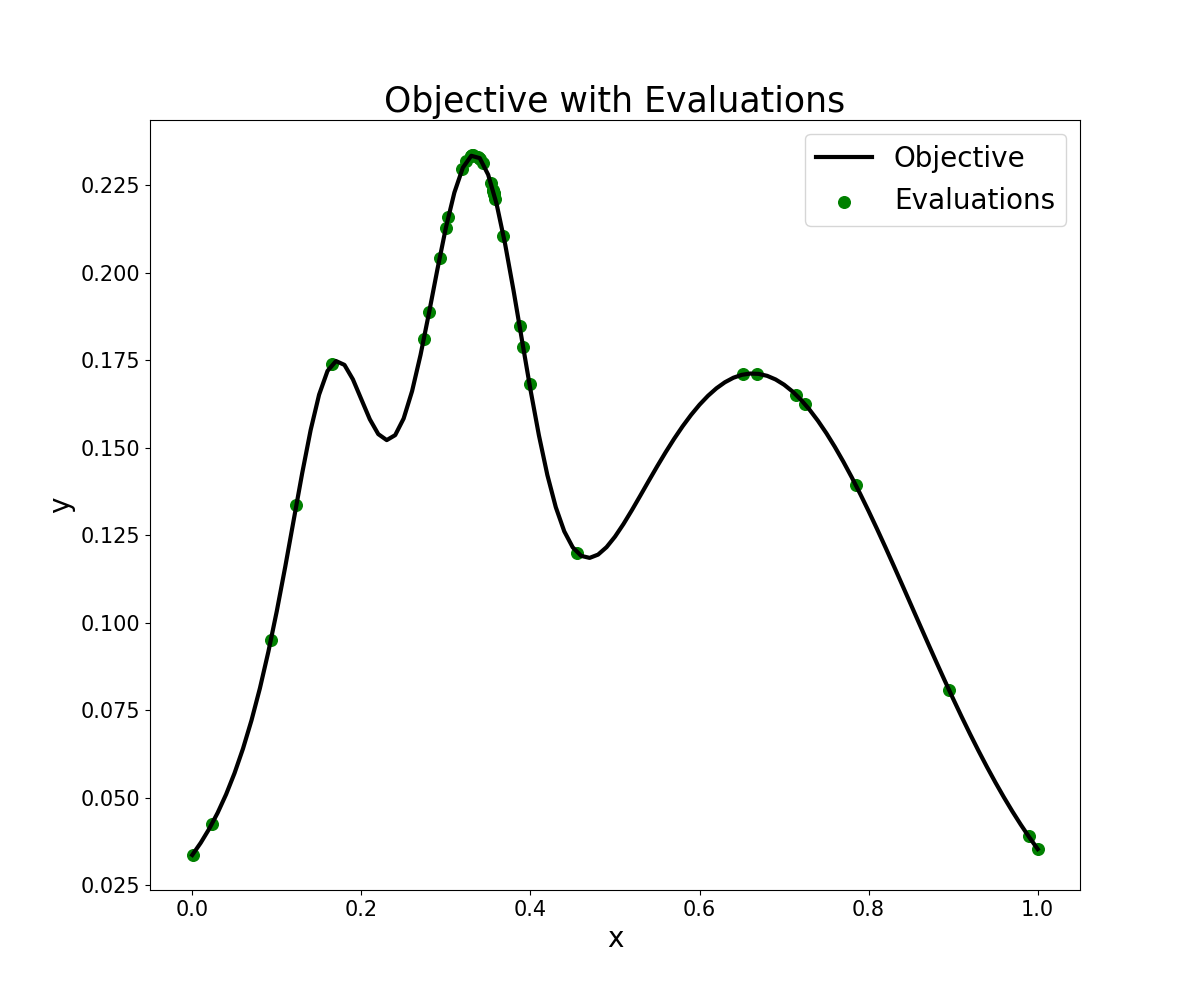

In [17]:
%%python
fig = plt.figure(figsize=[12,10])
ax = fig.add_subplot(1,1,1)
ax.plot(dfx, dfy, color='k', linewidth=3)
sc = ax.scatter(evaluationsx, evaluationsy, color='g', s=70)
ax.set_title("Objective with Evaluations", fontsize=25)
ax.set_xlabel("x", fontsize=20)
ax.set_ylabel("y", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(["Objective", "Evaluations"], prop={'size': 20})
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    fig.savefig(fo.name)
    retval = Image(filename=fo.name)